# Space Invaders with Deep Q-Networks

In this notebook I will try to create a DQN that surpasses human ability in playing Space Invaders.
Lets see how it goes...

In [1]:
#!pip install ale-py
#!pip uninstall torch torchvision -y
#!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu130
#!pip install gymnasium[atari]
#!pip install matplotlib

In [2]:
import torch
print("CUDA" if torch.cuda.is_available() else "cpu")

CUDA


## SCORING in Space invaders 

The SPACE INVADERS are worth 5, 10, 15, 20, 25, 30 points in
the first through sixth rows respectively. (See diagram.) The
point value of each target stays the same as it drops lower on
the screen. Each complete set of SPACE INVADERS is worth 630
points.


taken from https://atariage.com/manual_html_page.php?SoftwareLabelID=460

In [3]:
import logging
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
import ale_py
import random
import math
import numpy as np
from collections import defaultdict

gym.register_envs(ale_py)

# Training configuration
training_period = 250           # Record video every 250 episodes
num_training_episodes = 5_000  # Total training episodes
env_name = "ALE/SpaceInvaders-v5" # has a default obs tpye of rgb, 4 frames are skipped and the repeat action propability is 0.25

# Set up logging for episode statistics
logging.basicConfig(level=logging.INFO, format='%(message)s')

# Create environment with periodic video recording
# possible to activate full action space with full_action_space=True
# using grayscaling to reduce input of Q-Network
env = gym.make(env_name, render_mode="rgb_array", obs_type="grayscale")

# Record videos periodically (every 250 episodes)
env = RecordVideo(
    env,
    video_folder="space_invaders",
    name_prefix="training",
    episode_trigger=lambda x: x % training_period == 0  # Only record every 250th episode
)

# Track statistics for every episode (lightweight)
env = RecordEpisodeStatistics(env)

print(f"Training for {num_training_episodes} episodes")
print(f"Videos will be recorded every {training_period} episodes")
print(f"Videos saved to: space_invaders/")


Training for 5000 episodes
Videos will be recorded every 250 episodes
Videos saved to: space_invaders/


C:\Users\finnr\PycharmProjects\DQN-SpaceInvaders\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at C:\Users\finnr\PycharmProjects\DQN-SpaceInvaders\space_invaders folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [ ]:
from gymnasium.wrappers import FrameStackObservation, ResizeObservation

# ENV Changes
FRAME_STACK_SIZE = 4
RESIZE_X= 84
RESIZE_Y= 84


# This significantly reduces the input size from 210x160
env = ResizeObservation(env, (RESIZE_X, RESIZE_Y))

# This will stack the frame in order to provide the temporal information.
stacked_env = FrameStackObservation(env, stack_size=FRAME_STACK_SIZE)

In [ ]:
import torch.nn as nn


class QNetwork(nn.Module):

    def __init__(
        self,
        in_channels,
        action_space
        ):
        super().__init__()

        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=8, stride=4 ),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Infer fully-connected input size
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, RESIZE_X, RESIZE_Y)
            dummy_out = self.conv_stack(dummy)
            self.num_features = dummy_out.shape[1]

        self.fc = nn.Sequential(
            nn.Linear(self.num_features, 1024),
            nn.ReLU(),
            nn.Linear(1024, action_space)
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.fc(x)
        return x



In [6]:
from collections import namedtuple, deque
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)



In [ ]:
from torch.utils.tensorboard import SummaryWriter


class SpaceInvaderAgent:

    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
        frame_stacking: int = FRAME_STACK_SIZE,
        device: str | None = None,
        log_dir: str = "runs/space_invaders_dqn" # Added log_dir
    ):
        self.env = env

        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize TensorBoard Writer
        self.writer = SummaryWriter(log_dir)
        self.total_updates = 0 # Track global updates for the loss plot

        # Q-Network to represent the current policy
        self.policy_network = QNetwork(in_channels=frame_stacking, action_space=env.action_space.n).to(self.device)

        self.target_network = QNetwork(in_channels=frame_stacking, action_space=env.action_space.n).to(self.device)
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.target_network.eval()

        self.optimizer = torch.optim.Adam(self.policy_network.parameters(), lr=learning_rate)

        self.discount_factor = discount_factor  # How much we care about future rewards also known as gamma

        # Exploration parameters
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        # initialize a replay buffer
        self.memory = ReplayMemory(1_000_000)
        self.batch_size = 120

        # Track learning progress
        self.training_error = []

    def _obs_to_tensor(self, obs) -> torch.Tensor:
        """Convert a single stacked observation to a float32 tensor in NCHW."""
        obs = np.array(obs)  # handles FrameStackObservation / LazyFrames
        # Expected shapes:
        # - channels-first: (stack, H, W)
        # - channels-last:  (H, W, stack)
        if obs.ndim != 3:
            raise ValueError(f"Expected 3D obs (stack,H,W) or (H,W,stack), got shape {obs.shape}")

        if obs.shape[0] == FRAME_STACK_SIZE:
            # (stack, H, W)
            pass
        elif obs.shape[-1] == FRAME_STACK_SIZE:
            # (H, W, stack) -> (stack, H, W)
            obs = np.moveaxis(obs, -1, 0)
        else:
            raise ValueError(f"Can't infer channel dimension from obs shape {obs.shape}")

        return torch.from_numpy(obs).to(dtype=torch.float32, device=self.device)

    def get_action(self, obs) -> int:
        # With probability epsilon: explore (random action)
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()

        # With probability (1-epsilon): exploit (best known action)
        obs_t = self._obs_to_tensor(obs).unsqueeze(0)  # (1, C, H, W)
        with torch.no_grad():
            q = self.policy_network(obs_t)
            return int(torch.argmax(q, dim=1).item())

    def update(self):
        if len(self.memory) < 5000:
            return

        batch = self.memory.sample(self.batch_size)
        state_batch, action_batch, next_state_batch, reward_batch, done_batch = zip(*batch)

        # Convert each observation robustly to (C,H,W) then stack -> (B,C,H,W)
        state_batch = torch.stack([self._obs_to_tensor(s) for s in state_batch], dim=0)
        next_state_batch = torch.stack([self._obs_to_tensor(s) for s in next_state_batch], dim=0)

        action_batch = torch.as_tensor(action_batch, dtype=torch.int64, device=self.device).unsqueeze(1)
        reward_batch = torch.as_tensor(reward_batch, dtype=torch.float32, device=self.device)
        done_batch = torch.as_tensor(done_batch, dtype=torch.float32, device=self.device)

        # Compute Q-values for current states
        q_values = self.policy_network(state_batch).gather(1, action_batch).squeeze(1)

        # Compute target Q-values using the target network
        with torch.no_grad():
            max_next_q_values = self.target_network(next_state_batch).max(1)[0]
            target_q_values = reward_batch + self.discount_factor * max_next_q_values * (1.0 - done_batch)

        loss = nn.HuberLoss()(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Log Loss to TensorBoard
        self.writer.add_scalar("Loss/train", loss.item(), self.total_updates)
        self.total_updates += 1

        self.training_error.append(float(loss.item()))

    # Add a method to close the writer
    def close(self):
        self.writer.close()

    def decay_epsilon(self):
        """Reduce exploration rate after each episode."""
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

    # Add this inside the SpaceInvaderAgent class
def save_checkpoint(self, episode, filename="dqn_space_invaders.pth"):
    """Saves the policy network, optimizer, and current epsilon."""
    checkpoint = {
        'episode': episode,
        'model_state_dict': self.policy_network.state_dict(),
        'optimizer_state_dict': self.optimizer.state_dict(),
        'epsilon': self.epsilon,
    }
    torch.save(checkpoint, filename)
    print(f"--> Checkpoint saved at episode {episode}")

def load_checkpoint(self, filename):
    """Loads a previously saved checkpoint."""
    if os.path.isfile(filename):
        checkpoint = torch.load(filename, map_location=self.device)
        self.policy_network.load_state_dict(checkpoint['model_state_dict'])
        self.target_network.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint['epsilon']
        print(f"--> Loaded checkpoint from episode {checkpoint['episode']}")
        return checkpoint['episode']
    return 0



In [ ]:
import wandb

# Training hyperparameters
learning_rate = 0.0002
n_episodes = 100_000        # Number of runs
start_epsilon = 1.0         # Start with 100% random actions
epsilon_decay = start_epsilon / (n_episodes / 2)  # Reduce exploration over time
final_epsilon = 0.1         # Always keep some exploration


agent = SpaceInvaderAgent(
    env=stacked_env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)


# Initialize WandB
wandb.init(
    project="space-invaders-dqn",
    config={
        "learning_rate": learning_rate,
        "n_episodes": n_episodes,
        "batch_size": agent.batch_size,
        "epsilon_decay": epsilon_decay,
        "frame_stack": FRAME_STACK_SIZE,
        "device": str(agent.device),
    }
)


In [ ]:
steps_in_episode = []
global_steps = 0

for episode in tqdm(range(n_episodes)):
    state, info = stacked_env.reset()
    step_counter = 0
    done = False

    while not done:
        action = agent.get_action(state)
        next_state, reward, terminated, truncated, info = stacked_env.step(action)
        done = terminated or truncated

        step_counter += 1
        global_steps += 1 
        agent.memory.push(state, action, next_state, reward, float(done))

        agent.update()

        state = next_state

        if global_steps % 7_000 == 0:
            agent.target_network.load_state_dict(agent.policy_network.state_dict())
            agent.target_network.eval()
            print(f"Episode {episode} - Step {step_counter}: Updated target network.")

    # --- Tensorboard Logging
    agent.writer.add_scalar("Reward/episode", episode_reward, episode)
    agent.writer.add_scalar("Stats/Epsilon", agent.epsilon, episode)
    agent.writer.add_scalar("Stats/Episode_Length", step_counter, episode)

    agent.decay_epsilon()
    steps_in_episode.append(step_counter)

    # --- WandB Logging ---
    metrics = {
        "episode": episode,
        "reward": episode_reward,
        "epsilon": agent.epsilon
    }
    if agent.training_error:
        metrics["loss"] = agent.training_error[-1]
    
    wandb.log(metrics)

    # --- Save Model every 500 episodes ---
    if episode % 500 == 0:
        agent.save_checkpoint(episode)



# Close the writer when finished
agent.close()
# Finish Wandb
wandb.finish()



KeyboardInterrupt: 

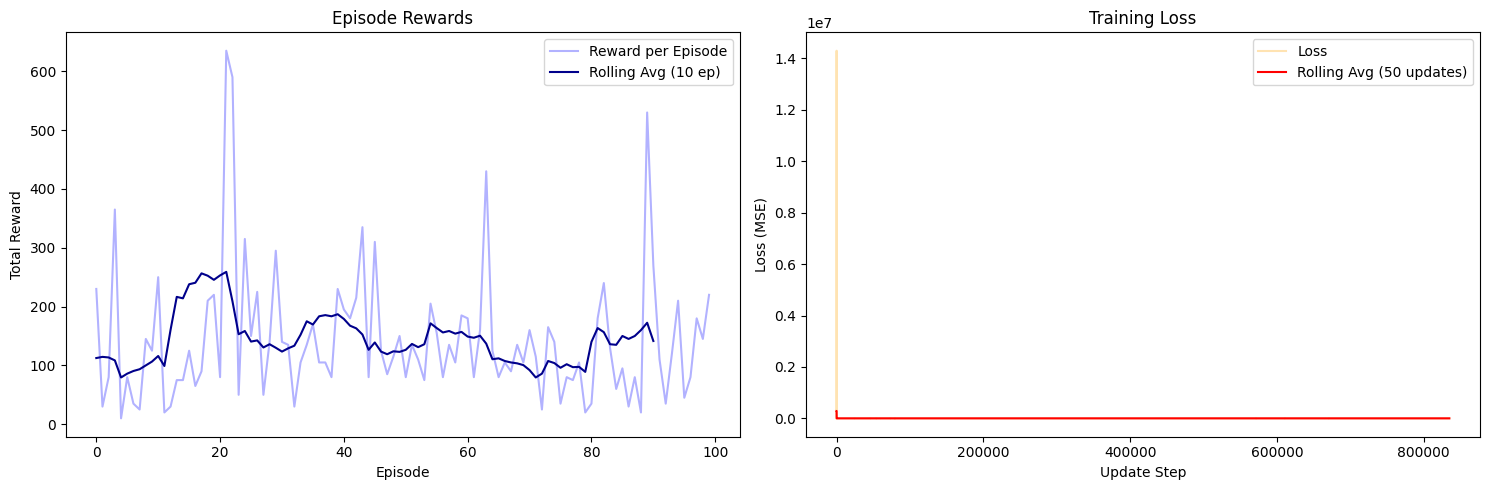

In [10]:
# python
import matplotlib.pyplot as plt
import numpy as np

def plot_training_results(agent, env, steps_per_episode):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

    # Episode Rewards
    if hasattr(env, 'return_queue') and len(env.return_queue) > 0:
        rewards = list(env.return_queue)
        ax1.plot(rewards, label='Reward per Episode', alpha=0.3, color='blue')
        if len(rewards) >= 10:
            rolling_avg = np.convolve(rewards, np.ones(10)/10, mode='valid')
            ax1.plot(rolling_avg, label='Rolling Avg (10 ep)', color='darkblue')
        ax1.set_title("Episode Rewards")
        ax1.set_xlabel("Episode")
        ax1.set_ylabel("Total Reward")
        ax1.legend()

    # Training Loss
    if len(agent.training_error) > 0:
        ax2.plot(agent.training_error, label='Loss', alpha=0.3, color='orange')
        if len(agent.training_error) >= 50:
            rolling_loss = np.convolve(agent.training_error, np.ones(50)/50, mode='valid')
            ax2.plot(rolling_loss, label='Rolling Avg (50 updates)', color='red')
        ax2.set_title("Training Loss")
        ax2.set_xlabel("Update Step")
        ax2.set_ylabel("Loss (MSE)")
        ax2.legend()
    else:
        ax2.text(0.5, 0.5, "No loss data yet.", ha='center', va='center')

    # Steps per Episode
    if steps_per_episode:
        ax3.plot(steps_per_episode, label='Steps per Episode', alpha=0.3, color='green')
        if len(steps_per_episode) >= 10:
            rolling_steps = np.convolve(steps_per_episode, np.ones(10)/10, mode='valid')
            ax3.plot(rolling_steps, label='Rolling Avg (10 ep)', color='darkgreen')
        ax3.set_title("Steps per Episode")
        ax3.set_xlabel("Episode")
        ax3.set_ylabel("Steps")
        ax3.legend()
    else:
        ax3.text(0.5, 0.5, "No steps data yet.", ha='center', va='center')

    plt.tight_layout()
    plt.show()

# Call with the recorded list:
plot_training_results(agent, env, steps_in_episode)
